# 1. Install python packages

# 2. GLM in fMRI analyses
Univariate fMRI analyses basically use the same linear regression model as we’ve explained above to model the activation of voxels (with some minor additions) based on some design-matrix.

FOR GLM with python 

1. Get Onsets of stimulus 
2. Convolving predictors with HRF function
3. Concate an intercept(BO) and predictors in a design matrix(X) ; np.hstack((intercept, pred1, pred2))
4. fitting the model and calculate betas 

In [1]:
# First some imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

%matplotlib inline

## Defining dependent variables : A simulated (y) in fMRI data 
What we want to model is one time-series from a single voxel 

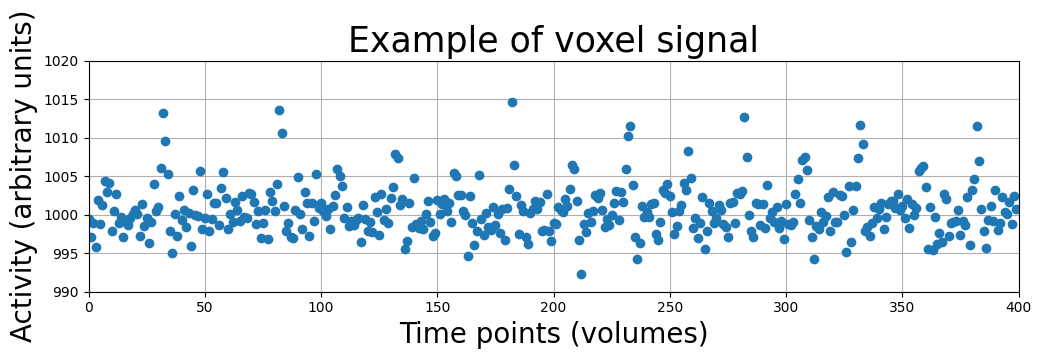

In [12]:
voxel_signal = np.load('example_voxel_signal.npy')
plt.figure(figsize=(12, 3))
plt.plot(voxel_signal, 'o')
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
x_lim, y_lim = (0, 400), (990, 1020)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

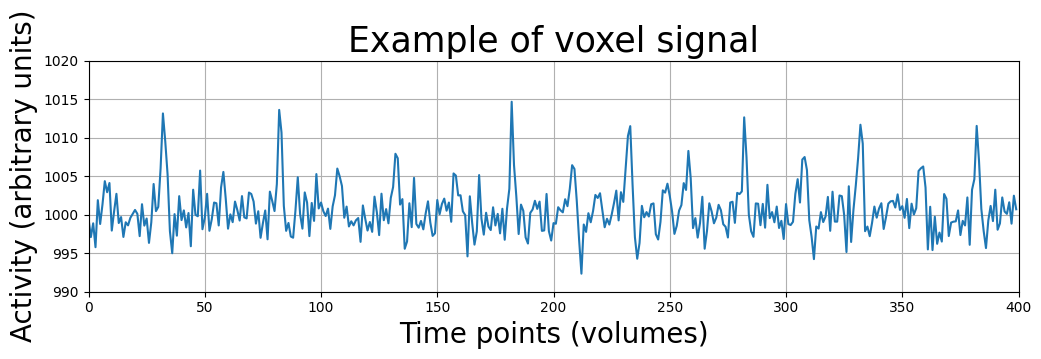

In [13]:
# 비록 실제로 수집하는 데이터는 2TR 이지만, 보다 쉬운 이해를 위해 연속변수로써 한 복셀에서의 시계열 데이터를 얻었다고 상정하고 다시 한번 데이터를 구해봅니다. 

plt.figure(figsize=(12, 3))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

## Defining independent variables : Onset timepoints

your predictors consist of whatever you think influenced your signal.
we could construct a predictor that predicts some response in the signal when a stimulus is present, and no response when a stimulus is absent.
Fortunately, we kept track of the onsets (in seconds!) of our stimuli during the experiment:

In [4]:
# 특정 실험에서 자극이 나타난 시점에 대한 정보를 얻어 우리가 만들고자하는 모델의 예측변수로 사용 
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)

onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210 310 410 510 610 710  60 160 260 360 460 560 660 760]


Shape of predictor: (800,)


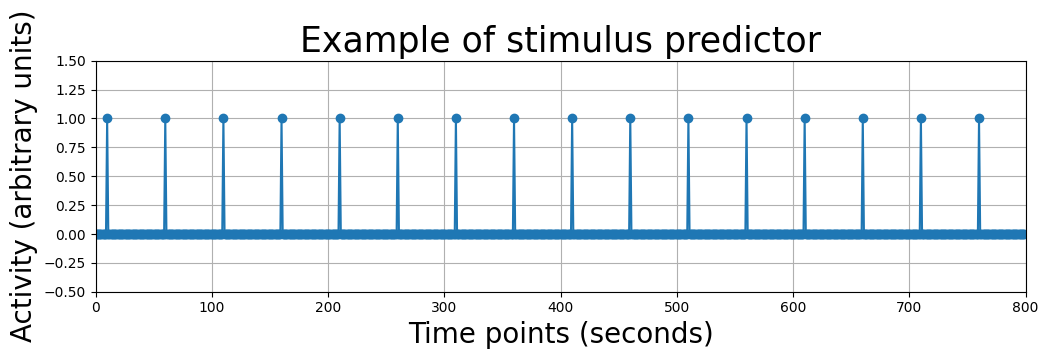

In [14]:
# 800초 동안 진행된 스캔에서 실제 자극이 나타난 시점을 1로 인코딩 

predictor_all = np.zeros(800)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

print("Shape of predictor: %s" % (predictor_all.shape,))
#print("\nContents of our predictor array:\n%r" % predictor_all.T)

plt.figure(figsize=(12, 3))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 800)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

### Resampling

실험 자극이 실제 제시된 시간은 초로 구성된 반면, fMRI 데이터는 2초 = 1TR로 구성되어 있다. 이처럼 서로 다른 척도를 해결하기 위해 Downsampling이라는 절차를 통해 자극이 나타난 시점을 TR로 환산한다.

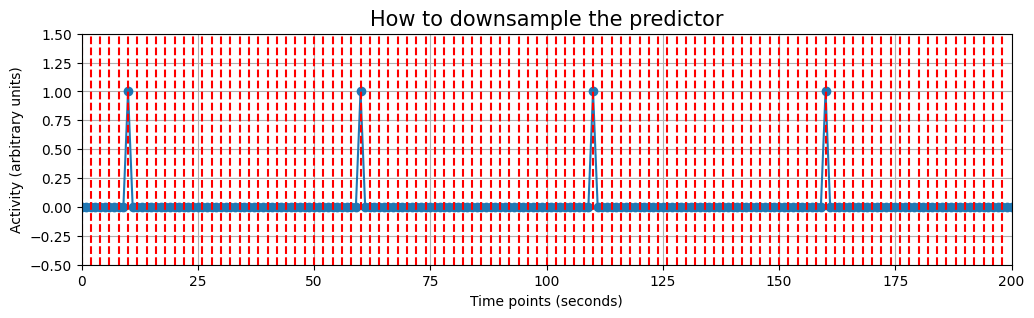

In [18]:
plt.figure(figsize=(12, 3))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=10)
plt.ylabel('Activity (arbitrary units)', fontsize=10)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=15)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

In [19]:
from scipy.interpolate import interp1d #새 함수에 변환된 새로운 변수에 저장시켜준다... 
original_scale = np.arange(0, 800, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-800, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 800, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 800, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 800 datapoints (0-800, in seconds)
Desired scale has 400 datapoints (0, 2, 4, ... 800, in volumes)
Downsampled predictor has 400 datapoints (in volumes)


## Convolution with HRF function 

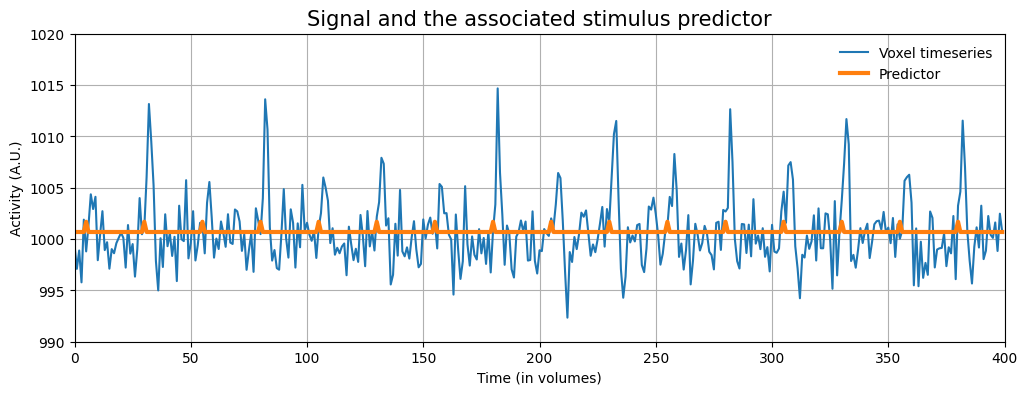

In [22]:
# Compare the x and y 

plt.figure(figsize=(12, 4))
plt.plot(voxel_signal)
plt.plot(predictor_all_ds + voxel_signal.mean(), lw=3)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('Time (in volumes)', fontsize=10)
plt.ylabel('Activity (A.U.)', fontsize=10)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=10, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=15)
plt.grid()
plt.show()

### Load HRF functions

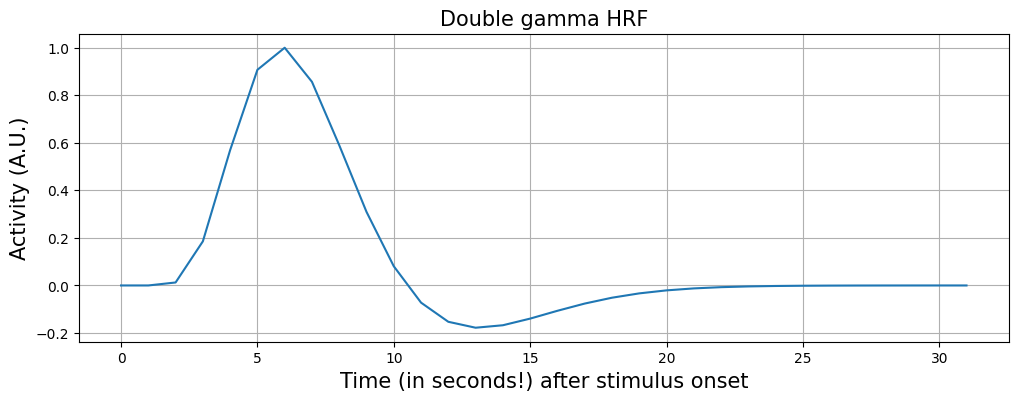

In [23]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

TR = 2
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()

t = np.arange(0, canonical_hrf.size)

plt.figure(figsize=(12, 4))
plt.plot(t, canonical_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=15)
plt.grid()
plt.show()

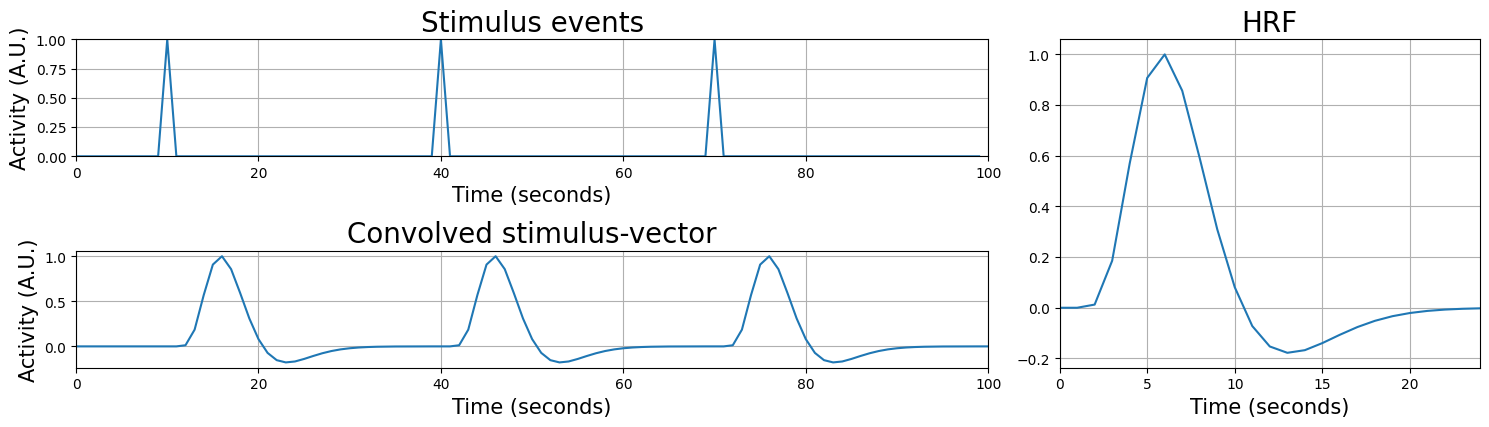

In [25]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf, 'full')
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

The shape of the convolved predictor after convolution: (831,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


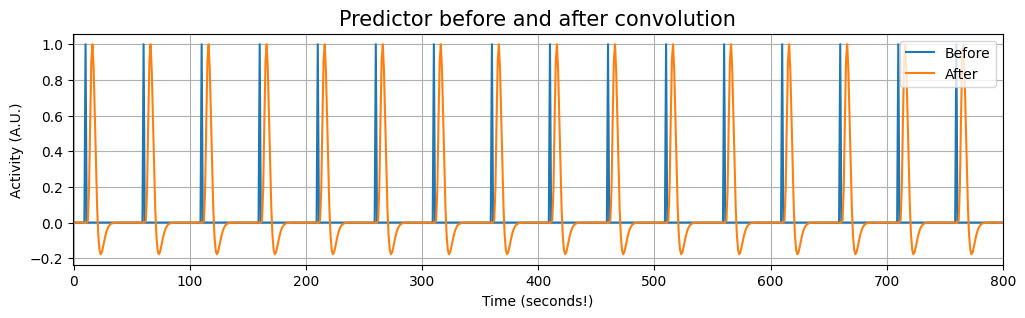

In [28]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))


plt.figure(figsize=(12, 3))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=15)
plt.xlabel("Time (seconds!)", fontsize=10)
plt.ylabel("Activity (A.U.)", fontsize=10)
plt.legend(['Before', 'After'], loc='upper right', fontsize=10)
plt.grid()
plt.show()

#### Linear Scaling 

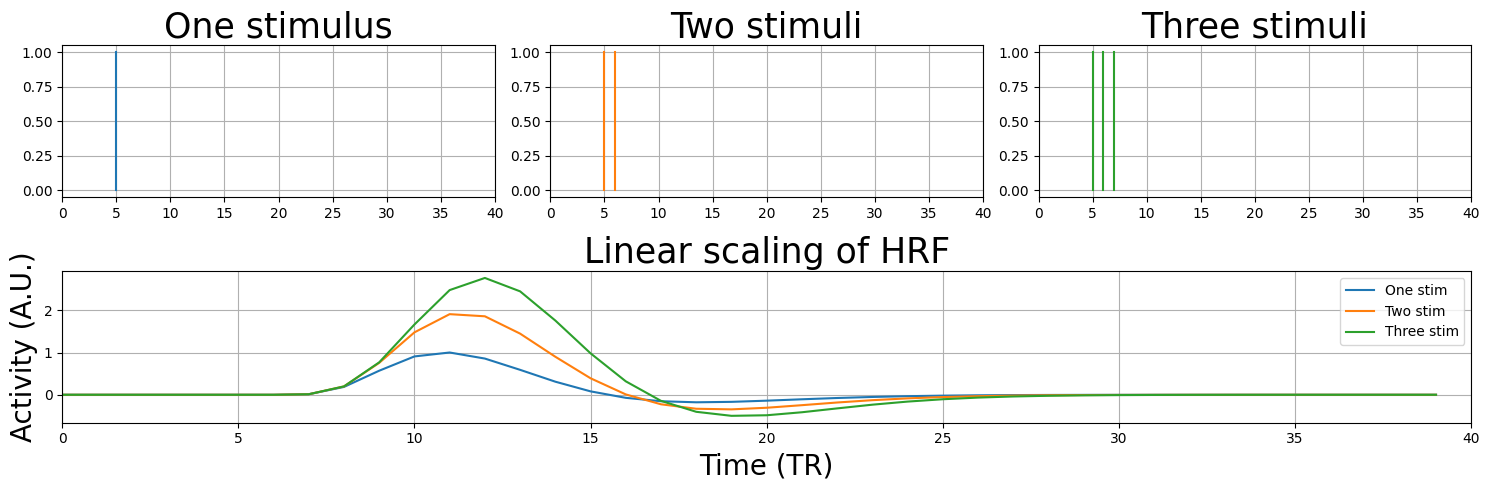

In [29]:
plt.figure(figsize=(15, 5))

N = 40
one_stim = np.zeros(N)
one_stim[5] = 1
one_stim_conv = np.convolve(one_stim, canonical_hrf)[:N]
two_stim = np.zeros(N)
two_stim[[5, 6]] = 1
two_stim_conv = np.convolve(two_stim, canonical_hrf)[:N]
three_stim = np.zeros(N)
three_stim[[5, 6, 7]] = 1
three_stim_conv = np.convolve(three_stim, canonical_hrf)[:N]

plt.subplot2grid((2, 3), (0, 0))
for ons in np.where(one_stim)[0]:
    plt.plot([ons, ons], [0, 1])

plt.xlim(0, N)
plt.title("One stimulus", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 1))
for ons in np.where(two_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:orange')

plt.xlim(0, N)
plt.title("Two stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 2))
for ons in np.where(three_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:green')

plt.xlim(0, N)    
plt.title("Three stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (1, 0), colspan=3)
plt.plot(one_stim_conv)
plt.plot(two_stim_conv)
plt.plot(three_stim_conv)
plt.legend(['One stim', 'Two stim', 'Three stim'])
plt.title('Linear scaling of HRF', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (TR)', fontsize=20)
plt.xlim(0, N)
plt.grid()
plt.tight_layout()
plt.show()

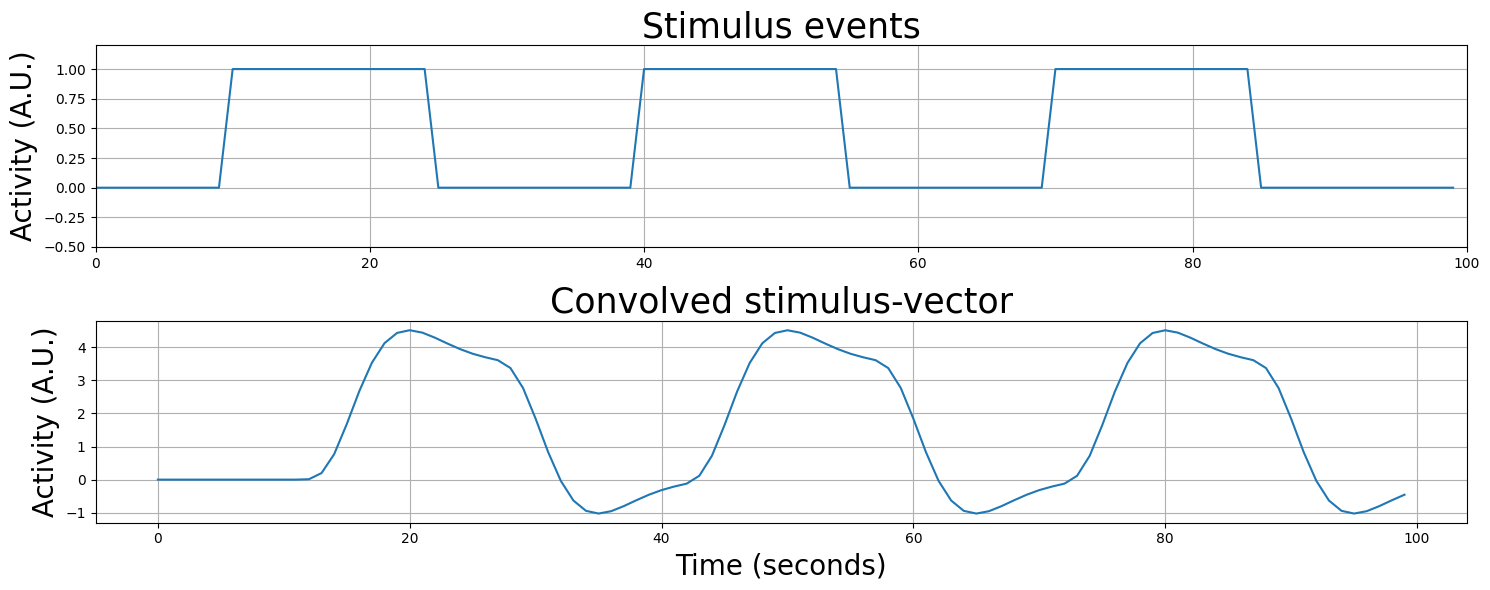

In [30]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=20)

plt.title('Stimulus events', fontsize=25)

convolved_stim_vector2 = np.convolve(random_stim_vector2, canonical_hrf)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

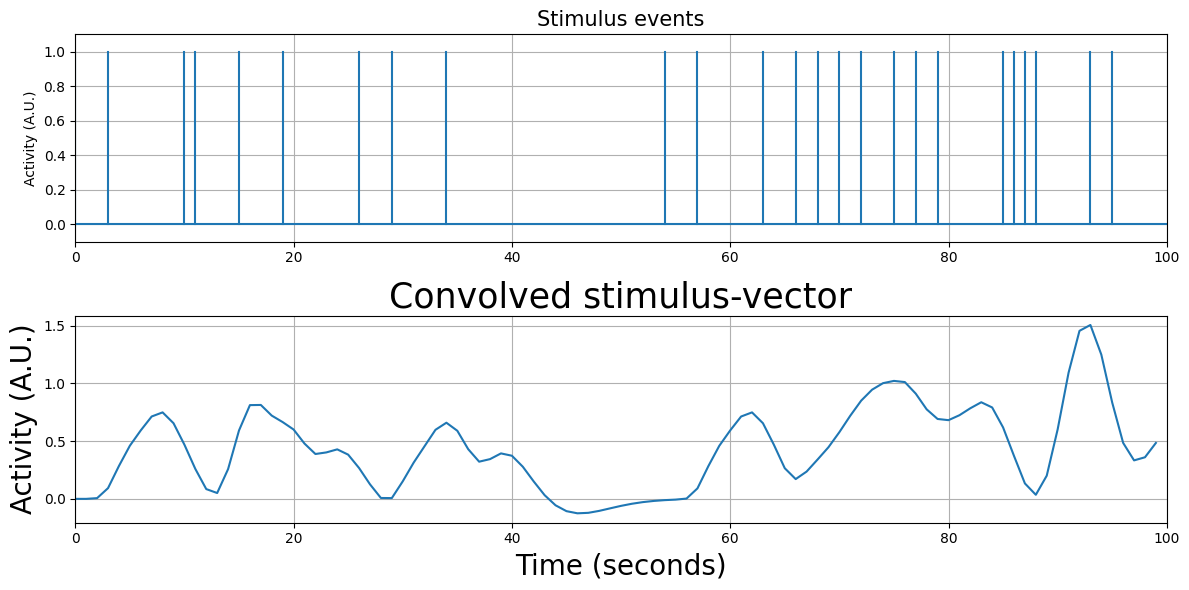

In [33]:
random_stimulus_onsets3 = np.random.randint(0, 100, 25)
random_stim_vector3 = np.zeros(100)
random_stim_vector3[random_stimulus_onsets3] = 1

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), '-', c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=10)
plt.title('Stimulus events', fontsize=15)
plt.grid()

convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, canonical_hrf, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

### Fitting the X to Y with betas 

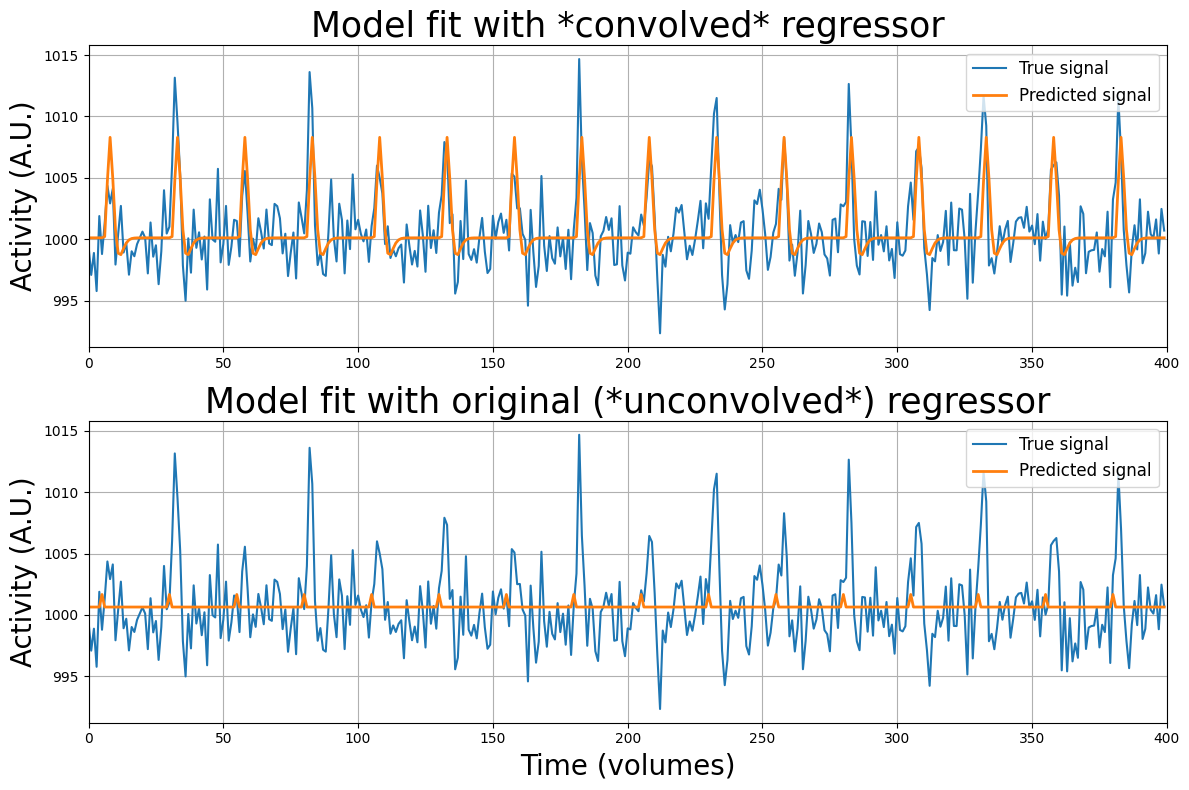

In [34]:
original_scale = np.arange(0, 800)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 800, 2)
predictor_conv_ds = resampler(desired_scale)


if predictor_all_ds.ndim == 1:  # do not remove this! This adds a singleton dimension, such that you can call np.hstack on it
    predictor_all_ds = predictor_all_ds[:, np.newaxis]

icept = np.ones((predictor_all_ds.size, 1))
X_simple = np.hstack((icept, predictor_all_ds))

if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]

intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv @ betas_conv, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
betas_simple = np.array([1000.64701684, 1.02307437])
plt.plot(X_simple @ betas_simple, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

In [35]:
from numpy.linalg import lstsq  # numpy implementation of OLS, because we're lazy

# Compare betas 
print('The beta-parameter of our stimulus-predictor is now: %.3f' % betas_conv[1])
print('... which is %.3f times larger than the beta of our original '
      'beta (based on the unconvolved predictors)!' % (betas_conv[1] / betas_simple[1]))

# Identifying the fittness models 
print('------Idendifying Model fittness---------')
y_hat_conv = X_conv @ betas_conv
y_hat_orig = X_simple @ lstsq(X_simple, voxel_signal, rcond=None)[0]

MSE_conv = ((y_hat_conv - voxel_signal) ** 2).mean()
MSE_orig = ((y_hat_orig - voxel_signal) ** 2).mean()

print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f." %
     (MSE_conv, MSE_orig))

R2_conv = 1 - (np.sum((voxel_signal - y_hat_conv) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
R2_orig = 1 - (np.sum((voxel_signal - y_hat_orig) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))

print("R-squared of model with convolution is %.5f and without convolution it is %.5f." % 
     (R2_conv, R2_orig))

The beta-parameter of our stimulus-predictor is now: 8.181
... which is 7.997 times larger than the beta of our original beta (based on the unconvolved predictors)!
------Idendifying Model fittness---------
MSE of model with convolution is 6.022 while the MSE of the model without convolution is 10.327.
R-squared of model with convolution is 0.41919 and without convolution it is 0.00388.


## Advanced tutorials 
- 실험 구조에 따라 만들어지는 design matrix 와, 그에 따른 예측되는 BOLD 신호의 차이를 확인해보기

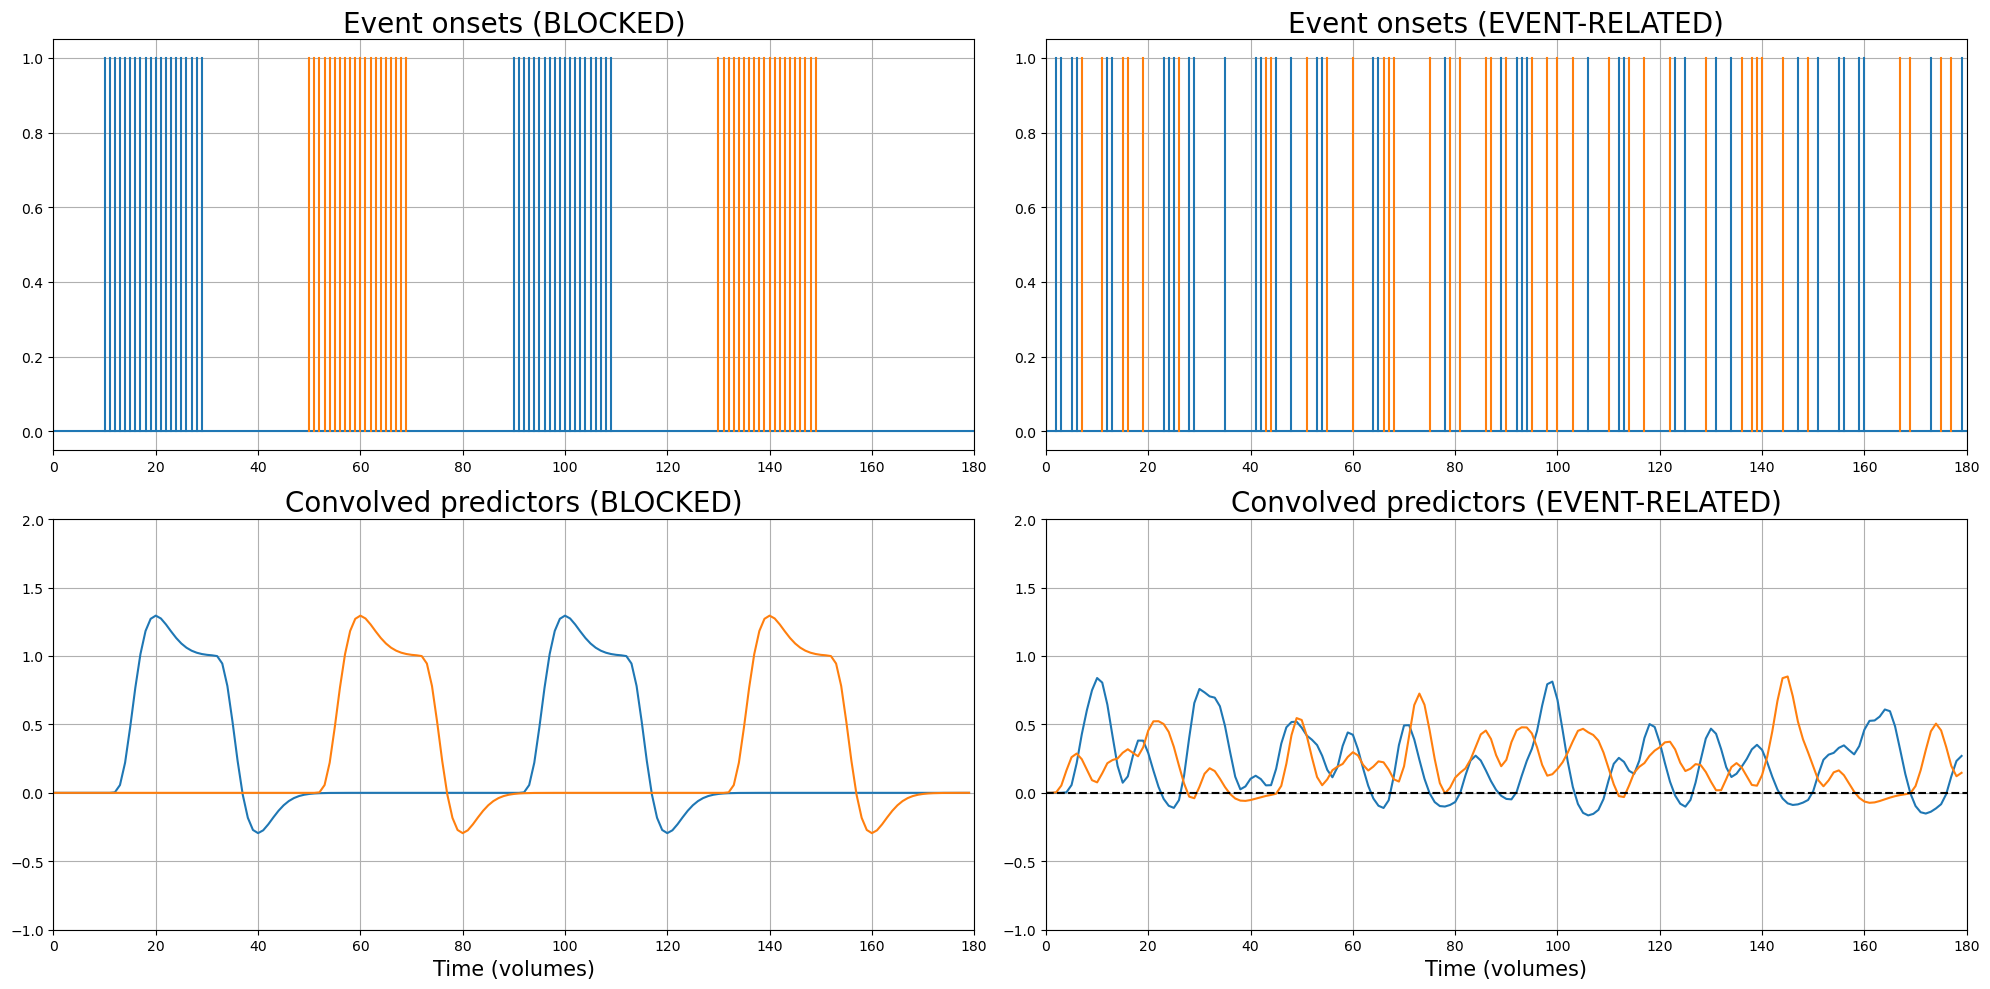

In [18]:
np.random.seed(2)

N = 180
dg_hrf = glover_hrf(tr=1, oversampling=1)

blocked_pred1_onsets = list(range(10, 30)) + list(range(90, 110))
blocked_pred2_onsets = list(range(50, 70)) + list(range(130, 150))
N_stim = len(blocked_pred1_onsets)
blocked_pred1, blocked_pred2 = np.zeros(N), np.zeros(N)
blocked_pred1[blocked_pred1_onsets] = 1
blocked_pred2[blocked_pred2_onsets] = 1

icept = np.ones((N, 1))
X_blocked = np.hstack((
    icept,
    np.convolve(blocked_pred1, dg_hrf)[:N, np.newaxis],
    np.convolve(blocked_pred2, dg_hrf)[:N, np.newaxis]
))

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.title("Event onsets (BLOCKED)", fontsize=20)
plt.xlim(0, N)
plt.axhline(0, c='tab:blue')
plt.grid()

for onset in blocked_pred1_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:blue')

for onset in blocked_pred2_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:orange')
    
plt.subplot(2, 2, 3)
plt.xlim(0, N)
plt.title("Convolved predictors (BLOCKED)", fontsize=20)
plt.ylim(-1, 2)
plt.plot(X_blocked[:, 1], c='tab:blue')
plt.plot(X_blocked[:, 2], c='tab:orange')
plt.grid()
plt.xlabel("Time (volumes)", fontsize=15)

er_stims = np.arange(N)
er_pred1_onsets = np.random.choice(er_stims, N_stim, replace=False)
er_stims_new = np.array([o for o in er_stims if o not in er_pred1_onsets])
er_pred2_onsets = np.random.choice(er_stims_new, N_stim, replace=False)
er_pred1, er_pred2 = np.zeros(N), np.zeros(N)
er_pred1[er_pred1_onsets] = 1
er_pred2[er_pred2_onsets] = 1

plt.subplot(2, 2, 2)
plt.xlim(0, N)
plt.title("Event onsets (EVENT-RELATED)", fontsize=20)
plt.axhline(0, c='tab:blue')
plt.grid()

for onset in er_pred1_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:blue')

for onset in er_pred2_onsets:
    plt.plot((onset, onset), (0, 1), c='tab:orange')

X_er = np.hstack((
    icept,
    np.convolve(er_pred1, dg_hrf)[:N, np.newaxis],
    np.convolve(er_pred2, dg_hrf)[:N, np.newaxis]
))

plt.subplot(2, 2, 4)

plt.title("Convolved predictors (EVENT-RELATED)", fontsize=20)
plt.ylim(-1, 2)
plt.plot(X_er[:, 1], c='tab:blue')
plt.plot(X_er[:, 2], c='tab:orange')
plt.axhline(0, ls='--', c='k')
plt.xlim(0, N)
plt.grid()
plt.xlabel("Time (volumes)", fontsize=15)

plt.tight_layout()
plt.show()

# 3. Subject-level analysis 

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Help Function

In [39]:
# Help Functions 
from nilearn.glm.first_level.hemodynamic_models import glover_hrf, glover_time_derivative
from scipy.linalg import toeplitz

def simulate_signal(onsets, conditions, TR=2, duration=None, icept=0, params_canon=None, params_tderiv=None,
                    params_deriv1=None, phi=None, std_noise=1, osf=100, rnd_seed=None, plot=True):
    """ Simulates a somewhat realistic voxel signal with an associated design matrix. """
    if rnd_seed is not None:
        np.random.seed(rnd_seed)
    
    conds = sorted(np.unique(conditions))
    P = len(conds)
    
    if duration is None:
        duration = np.max(onsets) + 30
    
    if params_canon is None:
        params_canon = np.zeros(P)

    # TMP FIX
    params_tderiv = params_deriv1
    
    if params_tderiv is None:
        params_tderiv = np.zeros(P)

    X = np.zeros((duration * osf, P))
    for ons, con in zip(onsets, conditions):
        X[int(ons * osf), conds.index(con)] = 1
        
    hrf = glover_hrf(tr=1, oversampling=osf)
    hrf_d = glover_time_derivative(tr=1, oversampling=osf)

    t_orig = np.arange(0, duration, 1 / osf)
    t_new = np.arange(0, duration, TR)
    
    Xconv = np.zeros((t_orig.size, P * 2))
    idx = 0
    for i, this_hrf in enumerate([hrf, hrf_d]):
        this_hrf /= this_hrf.max()
        for ii in range(P):
            Xconv[:, idx] = np.convolve(X[:, ii], this_hrf)[:t_orig.size]  
            idx += 1
    
    Xconv = np.c_[np.ones(Xconv.shape[0]), Xconv]
    params = np.r_[icept, params_canon, params_tderiv]
    y = Xconv @ params
    
    resampler = interp1d(t_orig, y)
    y = resampler(t_new)       
    
    if phi is None:
        noise_cov = std_noise ** 2 * np.eye(y.size)
    else:
        noise_cov = std_noise ** 2 * phi ** toeplitz(np.arange(y.size))
    
    y = y + np.random.multivariate_normal(np.zeros(y.size), noise_cov)

    Xconv_ds = np.zeros((t_new.size, Xconv.shape[1]))
    for i in range(Xconv.shape[1]):
        resampler = interp1d(t_orig, Xconv[:, i])
        Xconv_ds[:, i] = resampler(t_new)
    
    est_betas = np.linalg.lstsq(Xconv_ds, y, rcond=None)[0]
    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(y)
        plt.plot(Xconv_ds @ est_betas)
        plt.xlim(0, y.size)
        plt.legend(['y', 'y-hat'])
        plt.show()

    return y, Xconv_ds

## Simulated Data

Number of signals: 4
Size of signal for each run: 200

Number of design matrices: 4
Shape of design matrix per run: (200, 3)


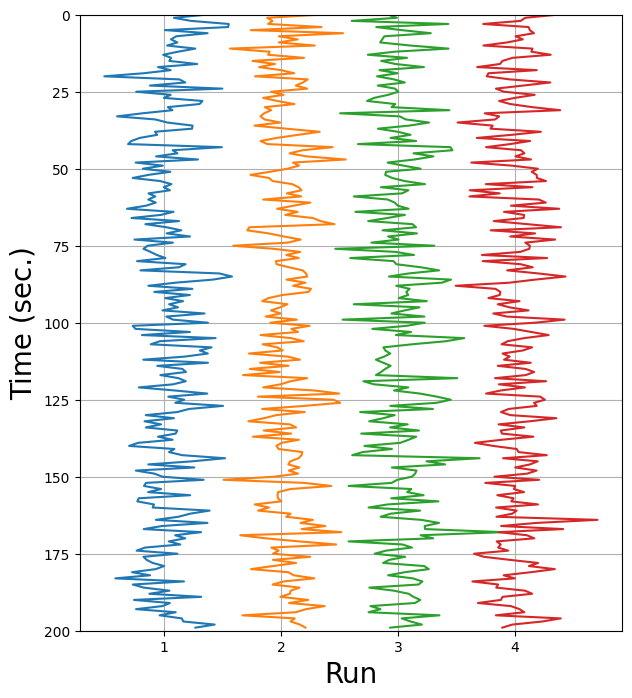

In [40]:
#from niedu.utils.nii import simulate_signal  # ignore the warning!

duration = 200
onsets = np.linspace(0, duration, 10, endpoint=False)
n_run = 4
Xs, ys = [], []
for run in range(n_run):  # simulate 4 signals / design matrices
    y, X = simulate_signal(
        onsets=onsets, conditions=np.tile(['A', 'B'], len(onsets) // 2),
        TR=1, duration=duration, params_canon=[2, 0.5], std_noise=2, plot=False, rnd_seed=run
    )
    ys.append(y)
    Xs.append(X[:, :3])  # remove tderivs

print("Number of signals: %i" % len(ys))
print("Size of signal for each run: %i\n" % ys[0].size)

print("Number of design matrices: %i" % len(Xs))
print("Shape of design matrix per run: %s" % (Xs[0].shape,))

plt.figure(figsize=(7, 8))
for i in range(n_run):
    plt.plot(ys[i] + i*10, np.arange(ys[i].size))

plt.ylim(ys[i].size, 0)    
plt.xticks(np.arange(n_run) * 10, np.arange(1, n_run+1))
plt.ylabel("Time (sec.)", fontsize=20)
plt.xlabel("Run", fontsize=20)
plt.grid()
plt.show()

## Traditional multilevel model 

Size of signal: 800


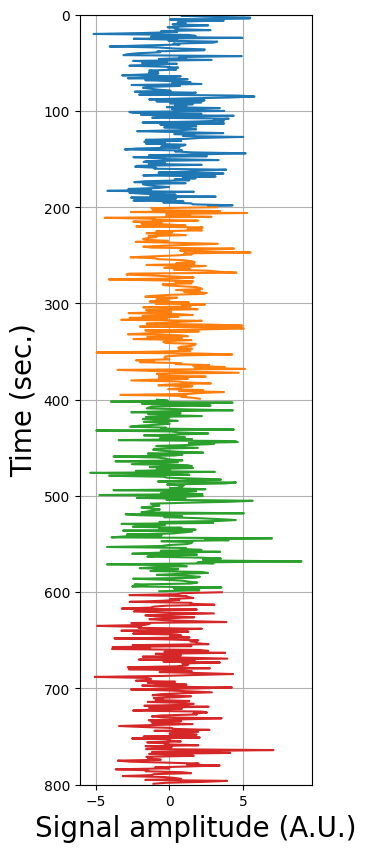

In [41]:
# Concatenate the signlas(y) in time to create a traditional multilevel model
y = np.concatenate(ys)
print("Size of signal: %i" % y.size)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Let's plot the concatenated signal (but color-code the runs)
plt.figure(figsize=(3, 10))
for i, ytmp in enumerate(ys):
    t = np.arange(duration * i, duration * (i + 1))
    plt.plot(ytmp, t, c=colors[i])

plt.ylim(y.size, 0)
plt.ylabel("Time (sec.)", fontsize=20)
plt.xlabel("Signal amplitude (A.U.)", fontsize=20)
plt.grid()
plt.show()

### Make Design matrix

In [42]:
# each predictor (including the intercept!) in each run gets its own column (i.e., predictor) in our multilevel design matrix:
X = np.zeros((len(Xs) * duration, len(Xs) * 3))
for i in range(len(Xs)):
    t = np.arange(duration * i, duration * (i + 1))
    X[t, i*3:(i+1)*3] = Xs[i]
    
# number of columns = number of conditions * number of runs
print("Shape of concatenated design matrix: %s" % (X.shape,))

Shape of concatenated design matrix: (800, 12)


/home/sincerely/.conda/envs/nilearn/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


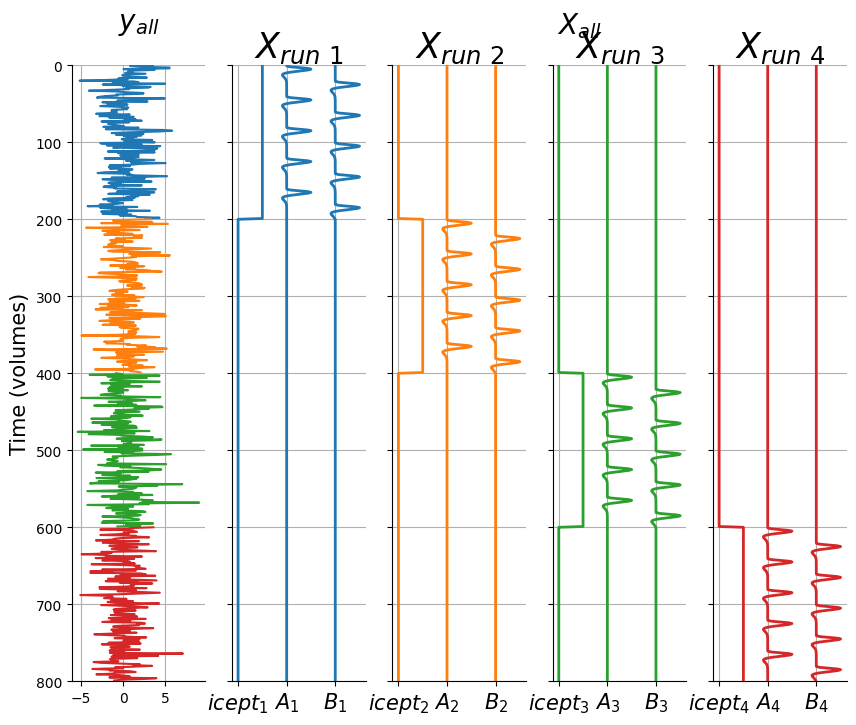

In [43]:
# concatenated signal and the concatenated design matrix in a single figure 
fig, axes = plt.subplots(ncols=len(Xs) + 1, figsize=(10, 8), sharey=True, sharex=False)

for i, ytmp in enumerate(ys):
    t = np.arange(duration * i, duration * (i + 1))
    axes[0].plot(ytmp, t, c=colors[i])
    axes[0].set_ylim(duration * n_run, 0)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    
    axes[i].grid()

    axes[i+1].set_title(r"$X_{run\ %i}$" % (i+1), fontsize=25)
    for ii in range(3):
        pred = X[:, (i*3)+ii]
        t = np.arange(duration * n_run)
        axes[i+1].plot(pred + (ii*2), t, c=colors[i], lw=2)
    
    axes[i+1].spines['right'].set_visible(False)
    axes[i+1].spines['top'].set_visible(False)
    axes[i+1].set_xticks([0, 2, 4])
    axes[i+1].set_xticklabels(
        [r'$icept_{%i}$' % (i+1), r'$A_{%i}$' % (i+1),r'$B_{%i}$' % (i+1)], fontsize=15
    )

plt.figtext(0.61, 0.92, r'$X_{all}$', fontsize=20)
axes[0].set_title(r'$y_{all}$', fontsize=20, y=1.045)

axes[0].set_ylabel("Time (volumes)", fontsize=15)
axes[i+1].grid()
fig.show()

### Univariate GLM 

In [44]:
from numpy.linalg import inv

#Fitting the DM to data 
av_betas = inv(X.T @ X) @ X.T @ y
av_betas = av_betas.squeeze()

# Make Contrast vector for each variable A & B 
ca = np.zeros(len(av_betas))
cb = np.zeros(len(av_betas))

ca[[1,4,7,10]] = 1/4
cb[[2,5,8,11]] = 1/4

# Get mean Betas for each variable A & B 
cvec_a = (av_betas*ca).sum()
cvec_b = (av_betas*cb).sum()

#직접 평균 구학.ㅣ.. 
hand_cvec_a = np.mean([av_betas[1], av_betas[4], av_betas[7], av_betas[10]])
hand_cvec_b = np.mean([av_betas[2], av_betas[5], av_betas[8], av_betas[11]])

print('compare cvec_a and hand_cvec_a :', cvec_a, ' ', hand_cvec_a)
print('compare cvec_b and hand_cvec_b :', cvec_b, ' ', hand_cvec_b)

compare cvec_a and hand_cvec_a : 2.1279802566340487   2.1279802566340487
compare cvec_b and hand_cvec_b : 0.603074034701293   0.603074034701293


## The summary statistics approach
Instead of running one single GLM for the concatenated data, it runs a GLM per unit within each level and subsequently “averages” the contrast estimates using the “summary statistics” approach.

In [45]:
# Run-wise betas for each variables 
betas = [] 
runwise_cb = np.zeros((2, len(Xs)))
for run in [0,1,2,3]: 
    beta = inv(Xs[run].T @ Xs[run]) @ Xs[run].T @ ys[run]
    betas.append(beta)
    runwise_cb[0, run] = beta[1]
    runwise_cb[1, run] = beta[2]
runwise_cb

array([[2.23777264, 2.43922507, 2.57225833, 1.26266498],
       [0.23364041, 0.87485915, 0.95346236, 0.35033422]])

In [48]:
runwise_cb1 = np.load('runwise_cb_answer.npy')
print(runwise_cb1)
ca = beta[1]* np.array([0, 1,0]) 
print(ca)

[[2.20097671 2.46979892 2.61944947 1.24812154]
 [0.35969887 0.79561876 0.90279101 0.37221361]]
[0.         1.26266498 0.        ]


In [49]:
# A betas become new dependent variables  for subject-level glm
y_rl = runwise_cb[0, :]
print(y_rl)

X_star = np.ones((4,1))
glm_mean = inv(X_star.T @ X_star) @ X_star.T @ y_rl

manual_mean = np.mean(y_rl)


if isinstance(glm_mean, np.ndarray):
    ans = glm_mean[0]
else:
    ans = glm_mean

np.testing.assert_almost_equal(ans, manual_mean)
print("Well done!", ' GLM:', glm_mean[0], '             manual_mean:', manual_mean )

[2.23777264 2.43922507 2.57225833 1.26266498]
Well done!  GLM: 2.127980256634048              manual_mean: 2.127980256634048


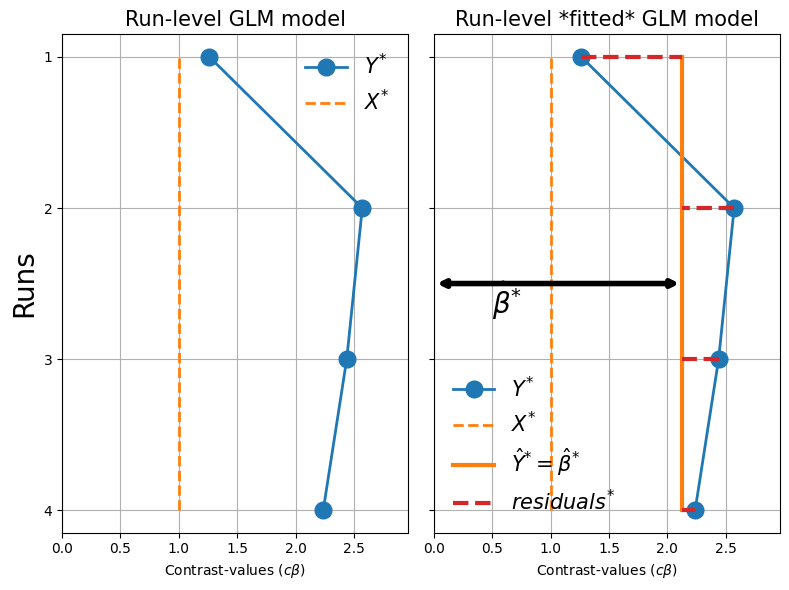

In [50]:
rnge = np.max(y_rl) - np.min(y_rl)
fig, axes = plt.subplots(ncols=2, figsize=(8, 6), sharey=True, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(y_rl, np.arange(1, y_rl.size+1), marker='o', ms=12, lw=2)
    ax.plot(np.ones(n_run), np.arange(1, n_run+1), ls='--', lw=2)
    ax.legend([r'$Y^{*}$', r'$X^{*}$'], fontsize=15, frameon=False)
    ax.set_yticks(np.arange(1, n_run+1)[::-1])
    ax.set_yticklabels(np.arange(1, n_run + 1), fontsize=10)
    ax.grid()
    ax.set_xlim(0, np.max(y_rl) + 0.3 * rnge)
    ax.set_xlabel(r"Contrast-values ($c\beta$)", fontsize=10)

    if i == 0:
        ax.set_ylabel(r"Runs", fontsize=20)
        ax.set_title("Run-level GLM model", fontsize=15)
    else:
        ax.set_title("Run-level *fitted* GLM model", fontsize=15)
        ax.plot(np.repeat(manual_mean, n_run), np.arange(1, n_run+1), c='tab:orange', lw=3)
        for i in range(n_run):
            ax.plot((y_rl[i], manual_mean), (i+1, i+1), c='tab:red', ls='--', lw=3)
            
        ax.annotate(text='', xy=(0, 2.5), xytext=(manual_mean, 2.5), arrowprops=dict(arrowstyle='<->', lw=4))
        ax.text(0.5, 2.3, r'$\hat{\beta}^{*}$', fontsize=20)
        ax.legend([r'$Y^{*}$', r'$X^{*}$', r'$\hat{Y}^{*} = \hat{\beta}^{*}$', r'$residuals^{*}$'],
                  fontsize=15, frameon=False, loc='lower left')
        
fig.tight_layout()   

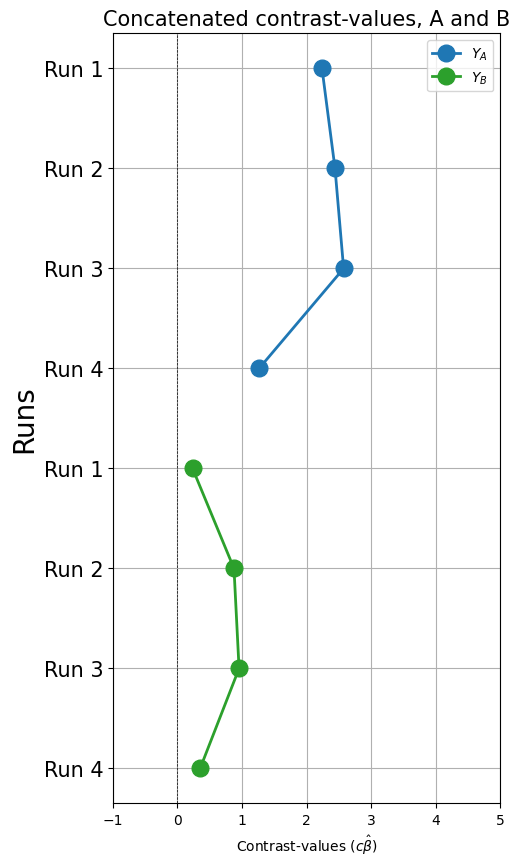

In [51]:
# order: A1, A2, A3, A4, B1, B2, B3, B4
y_AB = np.concatenate([runwise_cb[0, :], runwise_cb[1, :]])

plt.figure(figsize=(5, 10))
plt.plot(runwise_cb[0, :], np.arange(n_run), marker='o', ms=12, lw=2)
plt.plot(runwise_cb[1, :], np.arange(n_run, n_run * 2), c='tab:green', marker='o', ms=12, lw=2)
plt.yticks(np.arange(n_run * 2), ['Run ' + str(i) for i in np.tile(range(1, n_run+1), 2)], fontsize=15)
plt.xlim(-1, 5)
plt.ylabel("Runs", fontsize=20)
plt.xlabel(r"Contrast-values ($c\hat{\beta}$)", fontsize=10)
plt.title("Concatenated contrast-values, A and B", fontsize=15)
plt.axvline(0, c='black', ls='--', lw=0.5)
plt.legend([r'$Y_{A}$', r'$Y_{B}$'], fontsize=10)
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In [52]:
# Make design matrix for both A and B 
X_concate_data = np.zeros((8, 2))
X_concate_data[:4, 0] = 1
X_concate_data[4:, 1] = 1
print(X_concate_data)

#fitting X_concate_data to y_AB
concatenated_glm_mean = inv(X_concate_data.T @ X_concate_data) @ X_concate_data.T @ y_AB

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [37]:
if isinstance(concatenated_glm_mean, np.ndarray):
    ans = concatenated_glm_mean[0]
else:
    ans = concatenated_glm_mean

np.testing.assert_almost_equal(ans, glm_mean[0])
print("Well done!", ' Concatenated_glm_mean:', concatenated_glm_mean[0], '             glm_mean:', glm_mean[0] )

Well done!  Concatenated_glm_mean: 2.1279802566340473              glm_mean: 2.1279802566340473


# 4. Group-level analysis

In [55]:
N = 20
X = np.zeros((N * 2, 2))
X[:N, 0] = 1
X[N:, 1] = 1

print(X.shape)

(40, 2)


### simulated one voxel data 

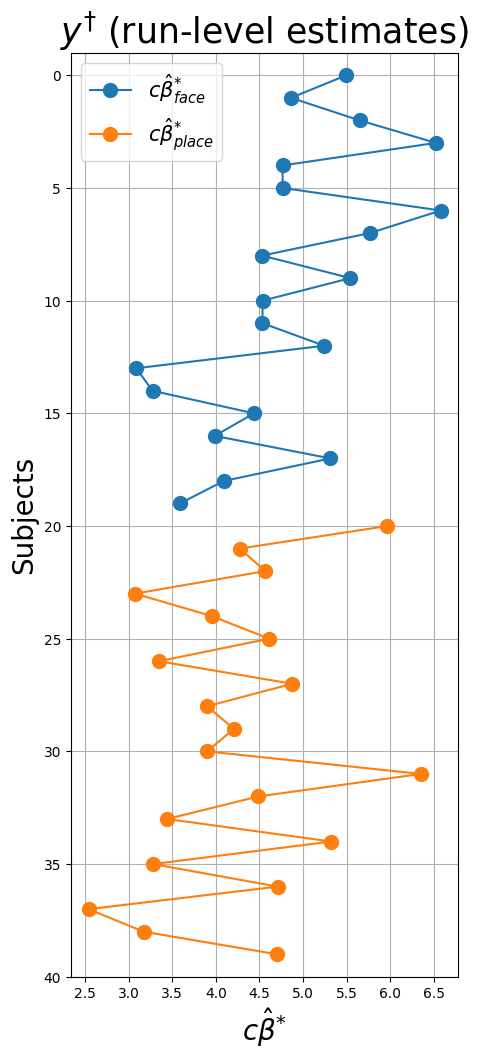

In [56]:
N = 20 # 20 subjects 
beta_f = 5 # activation magnitude in one voxel for f-condition stimulus 
beta_p = 4.5 # activation magnitude in one voxel for p-condition stimulus 
std_noise = 1
np.random.seed(42)
noise = np.random.normal(0, std_noise, size=N * 2)

y_sim = X @ np.array([beta_f, beta_p]) + noise # make Contrast betas for each subject which are made at the subject-level analysis 


#plotting the simulation 
plt.figure(figsize=(5, 12))
plt.plot(y_sim[:N], np.arange(y_sim.size // 2), marker='o', ms=10)
plt.plot(y_sim[N:], np.arange(y_sim.size // 2, y_sim.size), marker='o', ms=10)
plt.ylim(y_sim.size, -1)
plt.legend([r"$c\hat{\beta}^{*}_{face}$", r"$c\hat{\beta}^{*}_{place}$"], fontsize=15)
plt.ylabel("Subjects", fontsize=20)
plt.xlabel(r"$c\hat{\beta}^{*}$", fontsize=20)
plt.grid()
plt.title(r"$y^{\dagger}$ (run-level estimates)", fontsize=25)
plt.show()

### Statistic inference across subjects : Caculating T values 

t-values: In fact, the key to getting interpretable effects of our predictors is to divide (“normalize”) our beta-parameter(s) by some quantity that summarizes how well our model describes the data.

The effects (t-values) we measure in GLM analyses of fMRI data depend on two things: the effect measured and the (un)certainty of the effect, of which the latter term can be divided into the unexplained variance (“noise”) and the design variance (uncertainty of the parameter due to the design). 

In [57]:
# semi-help functions 
gl_params = inv(X.T @ X) @ X.T @ y_sim
gl_params  = gl_params.squeeze()

gl_y_hat_meter = X @ gl_params

N = 20
df = (N - X.shape[1])
print("Degrees of freedom: %i" % df)

design_variance = 0.05

gl_sigma_hat = np.sum((y_sim - gl_y_hat_meter) ** 2) / df
print("Sigma-hat (noise) is: %.3f" % gl_sigma_hat)

Degrees of freedom: 18
Sigma-hat (noise) is: 1.962


In [59]:
gl_params  = inv(X.T @ X) @ X.T @ y_sim


gl_tvalue =  gl_params / np.sqrt(gl_sigma_hat * design_variance)

print('Betas    for A and B:  ', round(gl_params[0],3),'  ', round(gl_params[1],3))
print('t-values for A and B: ', round(gl_tvalue[0],3), ' ', round(gl_tvalue[1],3))

Betas    for A and B:   4.829    4.234
t-values for A and B:  15.417   13.518


#### TODO Practice
Run a group-level random-effects GLM (using the variable X as design matrix and y_sim as dependent variable). 
Store the estimated parameters in a variable named gl_params. 
Then, compute the $t$-value for the contrast $\beta^{\dagger}_{face} > \beta^{\dagger}_{place}$ and store this in a variable named gl_tvalue.

In [60]:
# Let's just redo the linear regression (for clarity)

df = (N - X.shape[1])- 1
print("Degrees of freedom: %i" % df)
gl_sigma_hat =   np.sum((y_sim - gl_y_hat_meter) ** 2) / df
print("Sigma-hat (noise) is: %.3f" % gl_sigma_hat)


gl_tvalue = (gl_params[0]-gl_params[1]) / np.sqrt(gl_sigma_hat * design_variance)
#gl_tvalue = (gl_parms[0]-gl_parms[1]) / np.sqrt(1 * 0.05)
print("The t-value for the weight-parameter (beta = %.3f) is: %.3f" % ((gl_params[0]-gl_params[1]), gl_tvalue))

Degrees of freedom: 17
Sigma-hat (noise) is: 2.077
The t-value for the weight-parameter (beta = 0.595) is: 1.845
